# Análisis y preprocesamiento del corpus de Amazon Books Reviews
En este cuaderno documentamos la **Etapa 1** de la rúbrica: análisis del problema, limpieza del corpus y construcción de las primeras representaciones para el baseline.

## Objetivos de la sesión
- Entender la estructura y los metadatos del corpus de reseñas de Amazon Books.
- Limpiar y normalizar los campos necesarios para modelar interacciones usuario-libro.
- Dividir el conjunto en **Train/Dev/Test** respetando el orden temporal.
- Preparar las primeras representaciones (N-gramas/TF-IDF) para el baseline secuencial.

## Materiales y dependencias
- Dataset crudo: coloca el archivo descargado en `../../data/raw/` y documenta la fecha de descarga.
- Utilizaremos utilidades del paquete `sistema_recomendacion.src` (carga de datos, splits y representaciones).
- Registra las versiones de librerías utilizadas para reproducibilidad (se incluirán en `requirements.txt`).

In [25]:
import kagglehub
import shutil
from pathlib import Path
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
PROJECT_ROOT = Path("/home/lctr/SEMESTRES/SEMESTRE 5/MINERIA DE TEXTO/PROYECTO")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from sistema_recomendacion.src.data.loaders import load_books_metadata, load_books_ratings
from sistema_recomendacion.src.data.preprocessing import (
    basic_ratings_summary,
    deduplicate_reviews,
    drop_sparse_entities,
    normalize_ratings,
)
from sistema_recomendacion.src.utils.splits import temporal_train_dev_test_split

In [ ]:
# Download latest version
path = kagglehub.dataset_download("mohamedbakhet/amazon-books-reviews")

print("Path to dataset files:", path)


100%|██████████| 1.06G/1.06G [00:41<00:00, 27.5MB/s]

Extracting files...


Path to dataset files: /home/lctr/.cache/kagglehub/datasets/mohamedbakhet/amazon-books-reviews/versions/1


In [27]:
# Cargar los datos con utilidades del paquete
data_dir = PROJECT_ROOT / "sistema_recomendacion" / "data"
ratings = load_books_ratings(data_dir / "raw/Books_rating.csv")
metadata = load_books_metadata(data_dir / "raw/books_data.csv")

In [28]:
# Normalizar nombres de columnas para facilitar el manejo
ratings = ratings.rename(columns={
    "Id": "book_id",
    "Title": "book_title",
    "Price": "price",
    "User_id": "user_id",
    "profileName": "profile_name",
    "review/helpfulness": "helpfulness",
    "review/score": "rating",
    "review/time": "review_time",
    "review/summary": "review_summary",
    "review/text": "review_text",
})

metadata = metadata.rename(columns={
    "Title": "book_title",
    "publishedDate": "published_date",
    "ratingsCount": "ratings_count",
})

In [35]:
metadata_filtered = metadata.drop(columns=["image", "previewLink", "infoLink"])
ratings_filtered = ratings.drop(columns=["book_title", "price", "profile_name", "helpfulness"])

In [36]:
train_df, dev_df, test_df = temporal_train_dev_test_split(
    ratings_filtered,
    timestamp_col="review_time",
    dev_size=0.1,
    test_size=0.1,
    random_state=42,
    shuffle_dev=False
)

split_sizes = pd.Series({
    "train": len(train_df),
    "dev": len(dev_df),
    "test": len(test_df)
}, name="n_interactions")
split_sizes

train    1036854
dev       129607
test      129607
Name: n_interactions, dtype: int64

## Flujo de trabajo
1. **Exploración inicial**: inspeccionar campos, valores faltantes y distribución de reseñas por usuario/libro.
2. **Limpieza y normalización**: filtrar reseñas poco informativas, transformar fechas, manejar duplicados.
3. **Ingeniería de datos**: construir historiales ordenados, generar campos derivados (p. ej. rating normalizado).
4. **División Train/Dev/Test**: aplicar `temporal_train_dev_test_split` garantizando evidencia en este notebook.
5. **Validación de representaciones**: generar matriz TF-IDF/N-gramas y realizar un experimento control para verificar consistencia.
6. **Bitácora**: documentar decisiones clave y actualizar `docs/checklist_rubrica.md`.

In [7]:
# Exploración inicial de los datos
print("Metadata shape:", metadata.shape)
print("Ratings shape:", ratings.shape)

# Mostrar las primeras filas de cada DataFrame
print("Metadata sample:")
print(metadata.head())
print("\nRatings sample:")
print(ratings.head())

Metadata shape: (212403, 10)
Ratings shape: (2438213, 10)
Metadata sample:
                                               Title  \
0                     Its Only Art If Its Well Hung!   
1                           Dr. Seuss: American Icon   
2              Wonderful Worship in Smaller Churches   
3                      Whispers of the Wicked Saints   
4  Nation Dance: Religion, Identity and Cultural ...   

                                         description              authors  \
0                                    sin_descripcion     ['Julie Strain']   
1  Philip Nel takes a fascinating look into the k...       ['Philip Nel']   
2  This resource includes twelve principles in un...     ['David R. Ray']   
3  Julia Thomas finds her life spinning out of co...  ['Veronica Haddon']   
4                                    sin_descripcion      ['Edward Long']   

                                               image  \
0  http://books.google.com/books/content?id=DykPA...   
1  http://boo

In [29]:
# Valores faltantes
print("Missing values in metadata:")
print(metadata.isnull().sum())
print("\nMissing values in ratings:")
print(ratings.isnull().sum())

Missing values in metadata:
book_title             1
description        68442
authors            31413
image              52075
previewLink        23836
publisher          75886
published_date     25305
infoLink           23836
categories         41199
ratings_count     162652
dtype: int64

Missing values in ratings:
book_id                 0
book_title            208
price             2518829
user_id            561787
profile_name       561905
helpfulness             0
rating                  0
review_time             0
review_summary        407
review_text             8
dtype: int64
book_id                 0
book_title            208
price             2518829
user_id            561787
profile_name       561905
helpfulness             0
rating                  0
review_time             0
review_summary        407
review_text             8
dtype: int64


In [30]:
from dataclasses import asdict

summary_before = basic_ratings_summary(ratings, user_col="user_id", item_col="book_id")
pd.Series(asdict(summary_before))

n_users                  1.008972e+06
n_items                  2.219980e+05
n_interactions           3.000000e+06
interactions_per_user    2.416532e+00
interactions_per_item    1.351364e+01
dtype: float64

In [31]:
from pandas.api import types as ptypes

# Eliminar filas sin usuario o libro
ratings = ratings.dropna(subset=["user_id", "book_id"])

# Conversión de tipos y normalización de textos
if ptypes.is_integer_dtype(ratings["review_time"]):
    ratings["review_time"] = pd.to_datetime(ratings["review_time"], unit="s", errors="coerce")
else:
    ratings["review_time"] = pd.to_datetime(ratings["review_time"], errors="coerce")

ratings["book_title"] = ratings["book_title"].fillna("").str.strip()
ratings["review_summary"] = ratings["review_summary"].fillna("sin_resumen").str.strip()
ratings["review_text"] = ratings["review_text"].fillna("").str.strip()
ratings["rating"] = pd.to_numeric(ratings["rating"], errors="coerce")
ratings["price"] = pd.to_numeric(ratings["price"], errors="coerce")

metadata["book_title"] = metadata["book_title"].fillna("").str.strip()
metadata["description"] = metadata.get("description", pd.Series(dtype=str)).fillna("sin_descripcion")
metadata["authors"] = metadata.get("authors", pd.Series(dtype=str)).fillna("autor_desconocido")
metadata["publisher"] = metadata.get("publisher", pd.Series(dtype=str)).fillna("editorial_desconocida")
metadata["categories"] = metadata.get("categories", pd.Series(dtype=str)).fillna("categoria_desconocida")
metadata["published_date"] = pd.to_datetime(metadata.get("published_date"), errors="coerce")
metadata["ratings_count"] = pd.to_numeric(metadata.get("ratings_count"), errors="coerce").fillna(0)

# Claves normalizadas para facilitar joins
ratings["book_title_key"] = ratings["book_title"].str.lower().str.strip()
metadata["book_title_key"] = metadata["book_title"].str.lower().str.strip()
metadata = metadata.drop_duplicates(subset=["book_title_key"])

# Deduplicar reseñas múltiples del mismo usuario/libro (conservando la más reciente)
ratings = deduplicate_reviews(ratings, subset=["user_id", "book_id"], timestamp_col="review_time")

# Filtrar usuarios/libros con pocas interacciones
ratings = drop_sparse_entities(
    ratings, user_col="user_id", item_col="book_id", min_user_interactions=3, min_item_interactions=3
)

# Normalizar calificaciones a [0, 1] para usos posteriores
ratings["rating_normalized"] = normalize_ratings(ratings, rating_col="rating", min_rating=1.0, max_rating=5.0)

In [32]:
summary_after = basic_ratings_summary(ratings, user_col="user_id", item_col="book_id")
summary_comparison = pd.DataFrame({
    "before": pd.Series(asdict(summary_before)),
    "after": pd.Series(asdict(summary_after))
})
summary_comparison

,before,after
n_users,1.008972e+06,1.659510e+05
n_items,2.219980e+05,5.797900e+04
n_interactions,3.000000e+06,1.296068e+06
interactions_per_user,2.416532e+00,7.809944e+00
interactions_per_item,1.351364e+01,2.235409e+01


In [33]:
sizes_after = pd.Series({
    "ratings_rows": len(ratings),
    "ratings_cols": ratings.shape[1],
    "metadata_rows": len(metadata),
    "metadata_cols": metadata.shape[1]
}, name="dataset_shape")
sizes_after

ratings_rows     1296068
ratings_cols          12
metadata_rows     209457
metadata_cols         11
Name: dataset_shape, dtype: int64

In [34]:
post_clean_nulls = pd.DataFrame({
    "metadata": metadata.isnull().sum(),
    "ratings": ratings.isnull().sum()
})
post_clean_nulls

,metadata,ratings
authors,0.0,NaN
book_id,NaN,0.0
book_title,0.0,0.0
book_title_key,0.0,0.0
categories,0.0,NaN
description,0.0,NaN
helpfulness,NaN,0.0
image,51311.0,NaN
infoLink,23425.0,NaN
previewLink,23425.0,NaN


## Decisiones de limpieza y preprocesamiento
- Renombramos las columnas para estándar `snake_case` y añadimos `book_title_key` para uniones consistentes.
- Convertimos `review_time` a `datetime`, normalizamos texto y calificaciones (`rating_normalized`).
- Imputamos descripciones, autores, editoriales y categorías faltantes con marcadores explícitos.
- Conservamos solo la reseña más reciente por (`user_id`, `book_id`) y filtramos entidades con <3 interacciones.
- Eliminamos columnas con alta ausencia o sin valor para el baseline (`image`, `previewLink`, `infoLink`, `price`, `profile_name`, `helpfulness`).

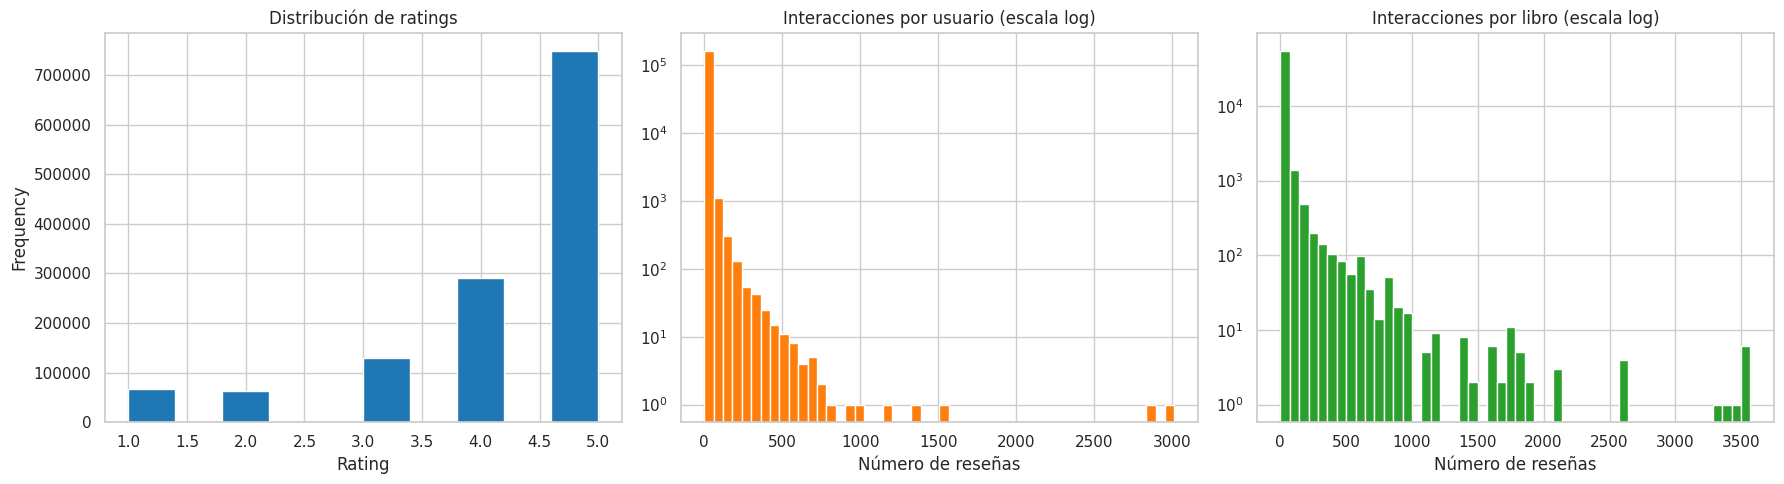

In [37]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ratings['rating'].plot(kind='hist', bins=10, ax=axes[0], color='#1f77b4')
axes[0].set_title('Distribución de ratings')
axes[0].set_xlabel('Rating')

user_activity = ratings.groupby('user_id').size()
axes[1].hist(user_activity, bins=50, color='#ff7f0e', log=True)
axes[1].set_title('Interacciones por usuario (escala log)')
axes[1].set_xlabel('Número de reseñas')

item_popularity = ratings.groupby('book_id').size()
axes[2].hist(item_popularity, bins=50, color='#2ca02c', log=True)
axes[2].set_title('Interacciones por libro (escala log)')
axes[2].set_xlabel('Número de reseñas')

plt.tight_layout()
plt.show()

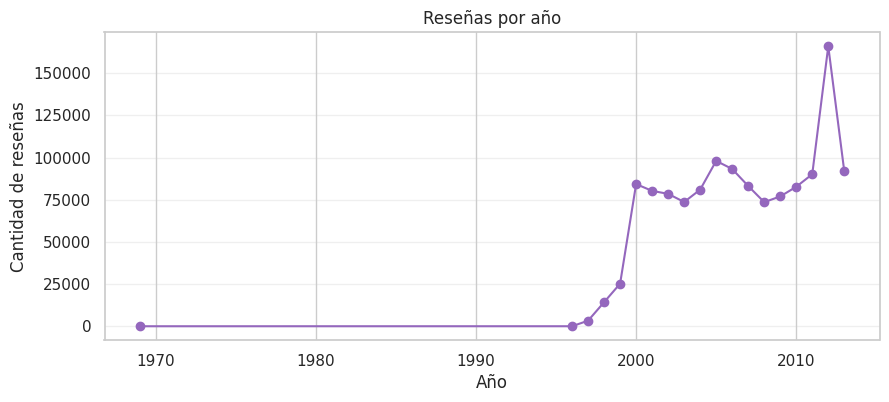

In [40]:
ratings_year = ratings['review_time'].dt.year.value_counts().sort_index()
plt.figure(figsize=(10, 4))
ratings_year.plot(kind='line', marker='o', color='#9467bd')
plt.title('Reseñas por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de reseñas')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

In [8]:
metadata.columns.tolist(), ratings.columns.tolist()

(['Title',
  'description',
  'authors',
  'image',
  'previewLink',
  'publisher',
  'publishedDate',
  'infoLink',
  'categories',
  'ratingsCount'],
 ['Id',
  'Title',
  'Price',
  'User_id',
  'profileName',
  'review/helpfulness',
  'review/score',
  'review/time',
  'review/summary',
  'review/text'])

In [41]:
# Guardar versiones procesadas
processed_dir = PROJECT_ROOT / "sistema_recomendacion" / "data" / "processed"
processed_dir.mkdir(exist_ok=True)

metadata_filtered.to_csv(processed_dir / "books_metadata_clean.csv", index=False)
ratings_filtered.to_csv(processed_dir / "books_ratings_clean.csv", index=False)
train_df.to_csv(processed_dir / "ratings_train.csv", index=False)
dev_df.to_csv(processed_dir / "ratings_dev.csv", index=False)
test_df.to_csv(processed_dir / "ratings_test.csv", index=False)

In [38]:
ratings_filtered.head()

,book_id,user_id,rating,review_time,review_summary,review_text,book_title_key,rating_normalized
2971446,B000G167FA,AZUNT3QP2CWTL,5.0,1969-12-31 23:59:59,Have you ever watched the fairies when the rai...,Although the new cover looks more like a Book ...,silver pennies,1.0
2971443,B000G167FA,AWVWX5F3YEJKZ,5.0,1969-12-31 23:59:59,Found again...,This book was given to me over 30 years ago by...,silver pennies,1.0
75750,0786280670,AE3SEXFJCQLJQ,1.0,1969-12-31 23:59:59,Meanspirited woman,The writing was okayish... But these details f...,"julie and julia: 365 days, 524 recipes, 1 tiny...",0.0
2971448,B000G167FA,AAFZZHA2I598B,5.0,1969-12-31 23:59:59,An incomparable children's classic,This book of children's poems has been enjoyed...,silver pennies,1.0
2006209,B00005O4HA,A3RTKL9KB8KLID,5.0,1996-08-17 00:00:00,The best mystery novel I have ever read,"I have been a mystery reader for decades, and ...",playing for the ashes,1.0


In [39]:
metadata_filtered.head()

,book_title,description,authors,publisher,published_date,categories,ratings_count,book_title_key
0,Its Only Art If Its Well Hung!,sin_descripcion,['Julie Strain'],editorial_desconocida,1996-01-01,['Comics & Graphic Novels'],0.0,its only art if its well hung!
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,NaT,['Biography & Autobiography'],0.0,dr. seuss: american icon
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],editorial_desconocida,2000-01-01,['Religion'],0.0,wonderful worship in smaller churches
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],iUniverse,NaT,['Fiction'],0.0,whispers of the wicked saints
4,"Nation Dance: Religion, Identity and Cultural ...",sin_descripcion,['Edward Long'],editorial_desconocida,NaT,categoria_desconocida,0.0,"nation dance: religion, identity and cultural ..."
